In [3]:
import pandas as pd
import os, json
import markdown
from dogeneval.utils.load_document import load_documents_and_contents


In [ ]:

full_folder = "/home/junetheriver/codes/qa_generation/huawei/data/UNC_20.9.5"

demo_folder = "/home/junetheriver/codes/qa_generation/huawei/data/UNC_20.9.5/网络部署/安全配置/UNC安全配置/必选配置/数据安全配置"

documents = load_documents_and_contents(full_folder)

In [15]:
from tqdm import tqdm

all_headings = []
for doc in tqdm(documents):
    html = markdown.markdown(doc['content'])
    # 将html中的各级标题提取出来
    from bs4 import BeautifulSoup
    import re

    soup = BeautifulSoup(html, 'html.parser')
    
    headers = []
    for tag in soup.find_all(re.compile('^h[1-6]$')):
        level = int(tag.name[1])
        text = tag.get_text().strip()
        headers.append((level, text))
    
    doc['headers'] = headers

    all_headings.append(headers)

100%|██████████| 38484/38484 [02:19<00:00, 276.12it/s]


In [16]:
with open('all_headings.json', 'w') as f:
    json.dump(all_headings, f, indent=2, ensure_ascii=False)

In [4]:
with open('all_headings.json', 'r') as f:
    all_headings = json.load(f)

In [5]:
all_headings = [' '.join([heading[1] for heading in headings]) for headings in all_headings]
len(all_headings)

38484

In [12]:
all_headings

['配置跟踪和日志匿名化功能（通过OM Portal和软件参数） 操作场景 对系统的影响 必备事项 操作步骤 验证方法',
 '更新密钥 操作场景 对系统的影响 必备事项 操作步骤']

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_headers(headings):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(headings)
    return tfidf_matrix

tfidf_matrix = vectorize_headers(all_headings)

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances

def cluster_with_dbscan(tfidf_matrix, eps=0.5, min_samples=10):
    """
    使用DBSCAN进行聚类。
    
    :param tfidf_matrix: 文档的TF-IDF矩阵
    :param eps: DBSCAN中定义簇的邻域距离阈值
    :param min_samples: 每个簇最小的样本数量
    :return: 聚类标签 (-1表示噪声点)
    """
    # 使用余弦距离来计算文本向量间的相似度
    distance_matrix = cosine_distances(tfidf_matrix)
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = db.fit_predict(distance_matrix)
    return labels

# 计算tfidf矩阵
tfidf_matrix = vectorize_headers(all_headings)

# 使用DBSCAN聚类
labels = cluster_with_dbscan(tfidf_matrix)

# 输出聚类结果
# for heading, label in zip(all_headings, labels):
#     print(f"Heading: {heading}, Cluster: {label}")

In [9]:
len(set(labels))

324

In [7]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

def cluster_with_hierarchical(tfidf_matrix, distance_metric='cosine', method='complete', max_d=None):
    """
    使用层次聚类进行聚类。
    
    :param tfidf_matrix: 文档的TF-IDF矩阵
    :param distance_metric: 距离度量方法 ('euclidean', 'cosine', etc.)
    :param method: 链接方法 ('single', 'complete', 'ward', etc.)
    :param max_d: 截断层次树的最大距离
    :return: 聚类标签
    """
    # 计算距离矩阵
    distance_matrix = cosine_distances(tfidf_matrix)
    
    # 进行层次聚类
    Z = linkage(distance_matrix, method=method, metric=distance_metric)
    
    # 可视化树状图
    plt.figure(figsize=(10, 7))
    dendrogram(Z)
    plt.show()
    
    # 根据最大距离来截断树状图，获取聚类标签
    if max_d is not None:
        labels = fcluster(Z, max_d, criterion='distance')
    else:
        labels = fcluster(Z, t=2, criterion='maxclust')  # 默认2个簇
    return labels

# 使用层次聚类并展示树状图
labels = cluster_with_hierarchical(tfidf_matrix, max_d=1.5)

# print(labels)

# # 输出聚类结果
# for heading, label in zip(all_headings, labels):
#     print(f"Heading: {heading}, Cluster: {label}")

NameError: name 'cosine_distances' is not defined

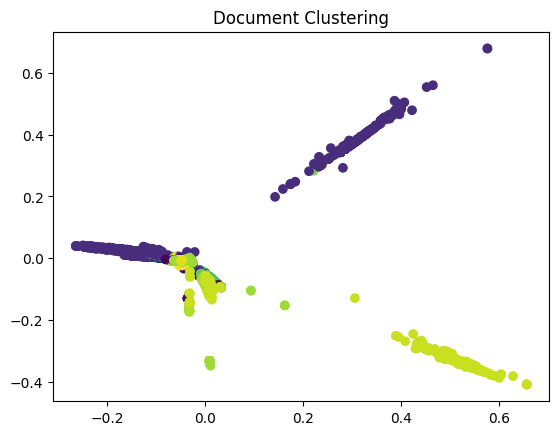

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters(tfidf_matrix, labels):
    # 忽略label为-1的样本
    valid_indices = labels != -1
    tfidf_matrix = tfidf_matrix[valid_indices]
    labels = labels[valid_indices]

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())
    
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
    plt.title('Document Clustering')
    plt.show()

# 可视化聚类结果
visualize_clusters(tfidf_matrix, labels)

In [24]:
# 展示若干个label下的heading例子
for label in set(labels):
    print(f"Cluster {label}:")
    cnt = 0
    print_cnt = 5
    for i, heading in enumerate(all_headings):
        if labels[i] == label:
            # print(f"  {heading}")
            if cnt < print_cnt:
                print(f"  {heading}")
            cnt += 1
    print(f"  Total: {cnt}")
    print()

Cluster 0:
  结语
  结语
  结语
  结语
  结语
  Total: 10

Cluster 1:
  查询紧急号码配置信息（LST NGEMGCNUM） 命令功能 注意事项 操作用户权限 参数说明 使用实例 结果如下 结果如下 输出结果说明
  查询运营商紧急呼叫功能配置（LST NGEMGCFG） 命令功能 注意事项 操作用户权限 参数说明 使用实例 结果如下 结果如下 输出结果说明
  查询NG接入CHR流程控制模板（LST NGACCCHRPRCTMPL） 命令功能 注意事项 操作用户权限 参数说明 使用实例 结果如下 结果如下 输出结果说明
  查询AMF小范围CHR上报规则配置（LST NGSRCHRCFG） 命令功能 注意事项 操作用户权限 参数说明 使用实例 结果如下 结果如下 输出结果说明
  增加5G PEI策略（ADD NGPEIPLCY） 命令功能 注意事项 操作用户权限 参数说明 使用实例
  Total: 384

Cluster 2:
  查询网络切片或DNN纠正配置（LST LOCALNSDNN） 命令功能 注意事项 操作用户权限 参数说明 使用实例 操作结果如下 操作结果如下 输出结果说明
  查询DNS本端实体（LST NGDNSLE） 命令功能 注意事项 操作用户权限 参数说明 使用实例 操作结果如下 操作结果如下 输出结果说明
  查询S1接口均衡操作信息(DSP S1BALANCEINFO) 命令功能 注意事项 本地用户权限 网管用户权限 参数说明 使用实例 操作结果如下 操作结果如下 操作结果如下 操作结果如下 输出结果说明
  显示GTP-U路径(DSP GTPUPATH) 命令功能 注意事项 本地用户权限 网管用户权限 参数说明 使用实例 操作结果如下: 操作结果如下: 操作结果如下: 输出结果说明
  显示迁移进度(DSP OFFLOAD) 命令功能 注意事项 本地用户权限 网管用户权限 参数说明 使用实例 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 操作结果如下 输出结果说明
  Total: 26

Cluster 3:
  查询IP与NF区域映射关系配置（LST NRFNFREGIO